# Exploratory analysis of single cell data with SAUCIE

In this notebook, we will use SAUCIE, a multitasking neural network, that can be used for visualization, clustering, batch correction and denoising of single cell data. We will apply it once again to the Shekhar et al. retinal bipolar data.

## 1. Imports

In [1]:
!pip install scprep
!pip install tensorflow==1.12.0

     |████████████████████████████████| 102kB 2.6MB/s 
     |████████████████████████████████| 83.1MB 67kB/s 
     |████████████████████████████████| 3.1MB 45.2MB/s 
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import sklearn.decomposition
import scprep
import sys
%matplotlib inline

SAUCIE is not available on PyPi, but we can download it from GitHub and add it to our Python path to run it without any further installation.

In [3]:
# download SAUCIE from Github
!git clone https://github.com/KrishnaswamyLab/SAUCIE.git

Cloning into 'SAUCIE'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 280 (delta 5), reused 16 (delta 5), pack-reused 260
Receiving objects: 100% (280/280), 5.77 MiB | 28.95 MiB/s, done.
Resolving deltas: 100% (160/160), done.


In [3]:
# add SAUCIE to the python path
sys.path.append('./SAUCIE/')
import SAUCIE

## 2. Loading the retinal bipolar data

We'll use the same retinal bipolar data you saw in preprocessing and visualization.

Alternatively, you may load your own data by replacing the Google Drive file ids with your own file ids.

Note that if you do, you will likely not have annotated celltype labels yet. Replace all references to `metadata['CELLTYPE']` with an entry from `metadata`, or your favorite gene. Parts of this notebook are only applicable if you have multiple batches, which you should encode in `metadata['sample_id']` as integers and `metadata['sample_name']` as strings.

In [0]:
scprep.io.download.download_google_drive("1GYqmGgv-QY6mRTJhOCE1sHWszRGMFpnf", "data.pickle.gz")
scprep.io.download.download_google_drive("1q1N1s044FGWzYnQEoYMDJOjdWPm_Uone", "metadata.pickle.gz")

In [6]:
data_raw = pd.read_pickle("data.pickle.gz")
data_raw.head()

,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610030E20Rik,0610037L13Rik,0610038B21Rik,0610039K10Rik,0610040B10Rik,0610040F04Rik,0610040J01Rik,0610043K17Rik,1010001B22Rik,1110001J03Rik,1110002E22Rik,1110002L01Rik,1110002O04Rik,1110004E09Rik,1110004F10Rik,1110007C09Rik,1110008F13Rik,1110008L16Rik,1110008P14Rik,1110012L19Rik,1110015O18Rik,1110017D15Rik,1110018N20Rik,1110019D14Rik,1110020A21Rik,1110025M09Rik,1110032A03Rik,1110034G24Rik,1110035H17Rik,1110037F02Rik,1110038B12Rik,...,Zswim8,Zufsp,Zw10,Zwilch,Zwint,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6,mmu-mir-684-2,mmu-mir-6948,mmu-mir-703,mt-Co1,mt-Co2,mt-Co3,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd4,mt-Nd5,mt-Nd6,mt-Rnr1,mt-Rnr2,mt-Ta,mt-Tc,mt-Te,mt-Ti,mt-Tl1,mt-Tl2,mt-Tm,mt-Tp,mt-Tq,mt-Ts2,mt-Tt,mt-Tv,mt-Tw,mt-Ty
Bipolar1_CTCCTAAACAAG,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.688017,0.0,0.000000,0.0,3.80143,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,8.064050,8.500255,2.688017,3.801430,4.655781,2.688017,0.000000,14.722874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Bipolar1_CTCGAGAGGCGC,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,2.612650,0.0,0.0,0.0,3.694845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,5.842062,4.525242,2.612650,2.612650,0.000000,0.000000,3.694845,2.612650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Bipolar1_AGCCTAAAGTAC,0.0,0.0,0.0,0.0,0.0,0.0,2.671658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,2.671658,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,9.254896,4.627448,5.974010,5.974010,5.343317,2.671658,3.778296,13.358292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Bipolar1_CGTGAAAATCAA,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,3.776948,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,2.670705,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4.625798,0.0,0.0,7.066022,5.341411,3.776948,5.971879,2.670705,0.000000,0.000000,9.251595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.670705,0.0,0.0,0.0,0.0,0.0,0.0
Bipolar1_CAACGTTCCGTA,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,2.624319,0.0,0.00000,0.0,2.624319,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.624319,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.624319,0.0,0.0,0.0,0.0,0.0,0.0,3.711348,0.0,0.0,6.428243,4.545455,2.624319,3.711348,3.711348,0.000000,2.624319,3.711348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Technically, the retinal bipolar data comes from six separate sequencing runs with subtle batch effects between then. For simplicity, we'll treat these six runs as coming from two batches---runs 1-3 and runs 4-6.

In [7]:
metadata = pd.read_pickle("metadata.pickle.gz")
# the batch ids are in the cell barcode names
metadata['batch'] = [int(index[7]) for index in metadata.index]
# for simplicity, we'll split the six batches into two groups -- 1-3 and 4-6
metadata['sample_id'] = np.where(metadata['batch'] < 4, 1, 2)
metadata['sample_name'] = np.where(metadata['batch'] < 4, 'Samples 1-3', 'Samples 4-6')
metadata.head()

,CLUSTER,SUB-CLUSTER,CELLTYPE,batch,sample_id,sample_name
Bipolar1_CTCCTAAACAAG,3.0,3,BC5A,1,1,Samples 1-3
Bipolar1_CTCGAGAGGCGC,9.0,9,BC1B,1,1,Samples 1-3
Bipolar1_AGCCTAAAGTAC,5.0,5,BC6,1,1,Samples 1-3
Bipolar1_CGTGAAAATCAA,1.0,1,Rod BC,1,1,Samples 1-3
Bipolar1_CAACGTTCCGTA,5.0,5,BC6,1,1,Samples 1-3


## 3. Preparing the data

Data for input to neural networks should generally be 100 or less input dimensions. If you have more than that, you should run PCA. If you have less, you should ensure that each of your data features are roughly normally distributed with mean 0 and standard deviation 1.

In [10]:
pca_op = sklearn.decomposition.PCA(100)
data = pca_op.fit_transform(data_raw)
data

array([[ -2.86639095,  16.11995588,   4.36943182, ...,   2.96254409,
         -2.46828878,  -1.67504411],
       [ -0.66863206,  13.21553129,  -4.89263864, ...,  -2.07909828,
          0.18115922,  -0.58069527],
       [  0.29665496,   6.85551504,  18.19106782, ...,   1.59523131,
          0.49603802,  -1.22392077],
       ...,
       [ 39.5113115 ,  -8.20886489, -10.16420662, ...,  -1.38808322,
          2.36708154,   0.16623689],
       [  3.13934964,  15.10619606,   3.69472754, ...,  -3.85082572,
         -1.8164434 ,   0.61178236],
       [ 42.90597659,  -9.79281524, -13.25214993, ...,   1.09461387,
         -0.41622395,  -2.06221088]])

In [11]:
n_features = data.shape[1]
n_features

100

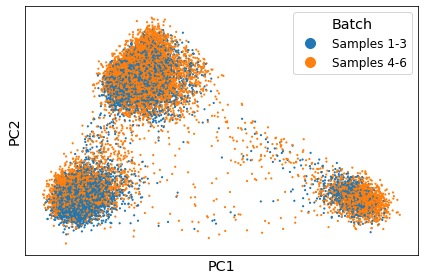

In [12]:
scprep.plot.scatter2d(data, c=metadata['sample_name'], ticks=False, label_prefix="PC", legend_title="Batch")

## 4. Running SAUCIE for visualization

SAUCIE contains a convenience class `SAUCIE.Loader` which allows us to easily send our data to the SAUCIE model without worrying about the underlying neural network mechanics. We'll build two of these -- one for training the model, which randomizes the order of the data points, and one for evaluating the model, which sends the points through in order so we can compare them to our metadata object.

In [0]:
# in training: get random order
loader_train = SAUCIE.Loader(data, labels=metadata['sample_id'], shuffle=True)
# to evaluate: get same order, so we know which row is which
loader_eval = SAUCIE.Loader(data, labels=metadata['sample_id'], shuffle=False)

Each time we run SAUCIE, we should call `tf.reset_default_graph()` to clear any previous runs. Then all we need to do to actually run SAUCIE is to create the model `SAUCIE.SAUCIE(n_features)` and run `model.train(loader)`!

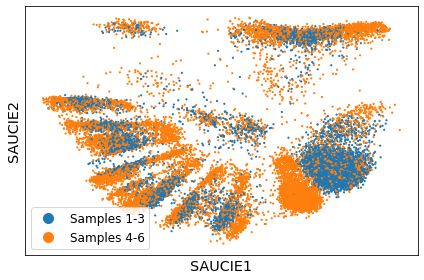

In [14]:
# clear the computational graph
tf.reset_default_graph()
# build the SAUCIE model
model = SAUCIE.SAUCIE(n_features)
# train the model!
model.train(loader_train, steps=1000)

# get the visualization layer
embedding, _ = model.get_embedding(loader_eval)

# plot the results
scprep.plot.scatter2d(embedding, c=metadata['sample_name'], ticks=False, label_prefix="SAUCIE")

### Exercise - examine the visualization

Try coloring the SAUCIE visualization by features in the `metadata` data frame, or by gene expression from `data_raw`. Compare this to what you saw when visualizing the same dataset with PCA, PHATE, t-SNE or UMAP.

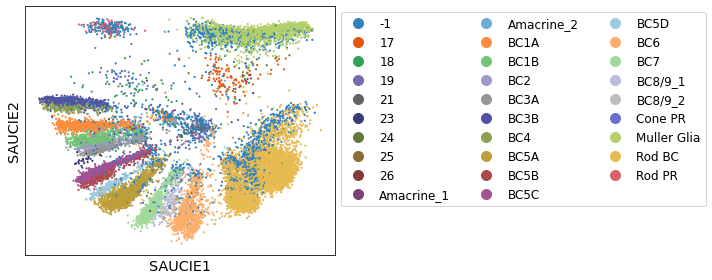

In [16]:
# =======
# plot `embedding` colored by the feature or meta-feature of your choice
scprep.plot.scatter2d(embedding, c=metadata['CELLTYPE'], 
                      ticks=False, label_prefix="SAUCIE", figsize=(10,4), legend_anchor=(1,1))
# =======

In [ ]:
# ======
# run the visualization of your choice
# you may need to install PHATE or UMAP (`!pip install phate` or `!pip install umap-learn`)
!pip install phate
import phate

Calculating PHATE...
  Running PHATE on 21552 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 86.90 seconds.
    Calculating affinities...
    Calculated affinities in 42.97 seconds.
  Calculated graph and diffusion operator in 129.99 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 6.22 seconds.
    Calculating KMeans...
    Calculated KMeans in 25.74 seconds.
  Calculated landmark operator in 33.78 seconds.
  Calculating optimal t...
    Automatically selected t = 20
  Calculated optimal t in 4.62 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.12 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 6.78 seconds.
Calculated PHATE in 177.34 seconds.


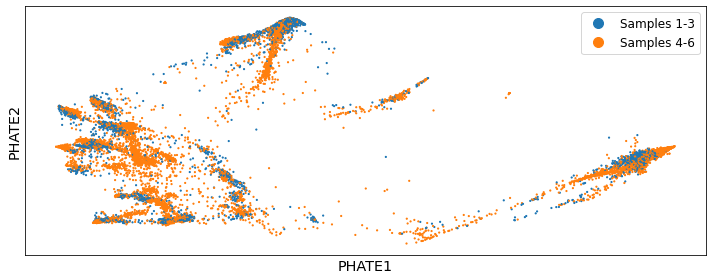

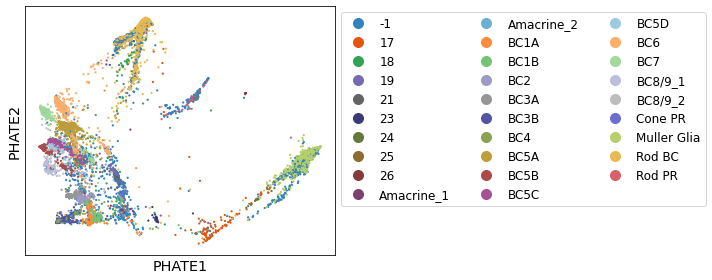

In [18]:
embedding_op = phate.PHATE()
alt_embedding = embedding_op.fit_transform(data)
# plot `alt_embedding` colored by the sample labels and the feature or meta-feature of your choice
scprep.plot.scatter2d(alt_embedding, c=metadata['sample_name'], 
                      ticks=False, label_prefix="PHATE", figsize=(4,4))
scprep.plot.scatter2d(alt_embedding, c=metadata['CELLTYPE'], 
                      ticks=False, label_prefix="PHATE", figsize=(10,4), legend_anchor=(1,1))
# ======

### Discussion

1. What do you notice about the SAUCIE visualization?
2. How does the visualization compare to UMAP and PHATE?
3. When do you think it would be useful to use SAUCIE instead of any other visualization technique?

## 5. Running SAUCIE for batch correction

#### Characterizing the batch effect

We noticed in the visualization above that there is a small but noticeable difference between the batches. Let's take a look at the differences between batches to understand the batch effect.

In [19]:
# Calculate the differential expression by calculating the t-statistic between samples
de_results = scprep.stats.differential_expression(data_raw.loc[metadata['sample_name'] == 'Samples 1-3'],
                                                  data_raw.loc[metadata['sample_name'] == 'Samples 4-6'],
                                                  measure='ttest')
de_results.iloc[0:20,:]

,ttest,rank
Xist,-115.055574,0
Platr17,-55.714918,1
Smim10l1,-55.040209,2
Tsix,-49.856357,3
Mir124a-1hg,-49.386624,4
Snhg20,-49.029454,5
BC033916,48.832887,6
2700089E24Rik,42.770984,7
Rsrp1,42.428391,8
Zfp638,-42.132161,9


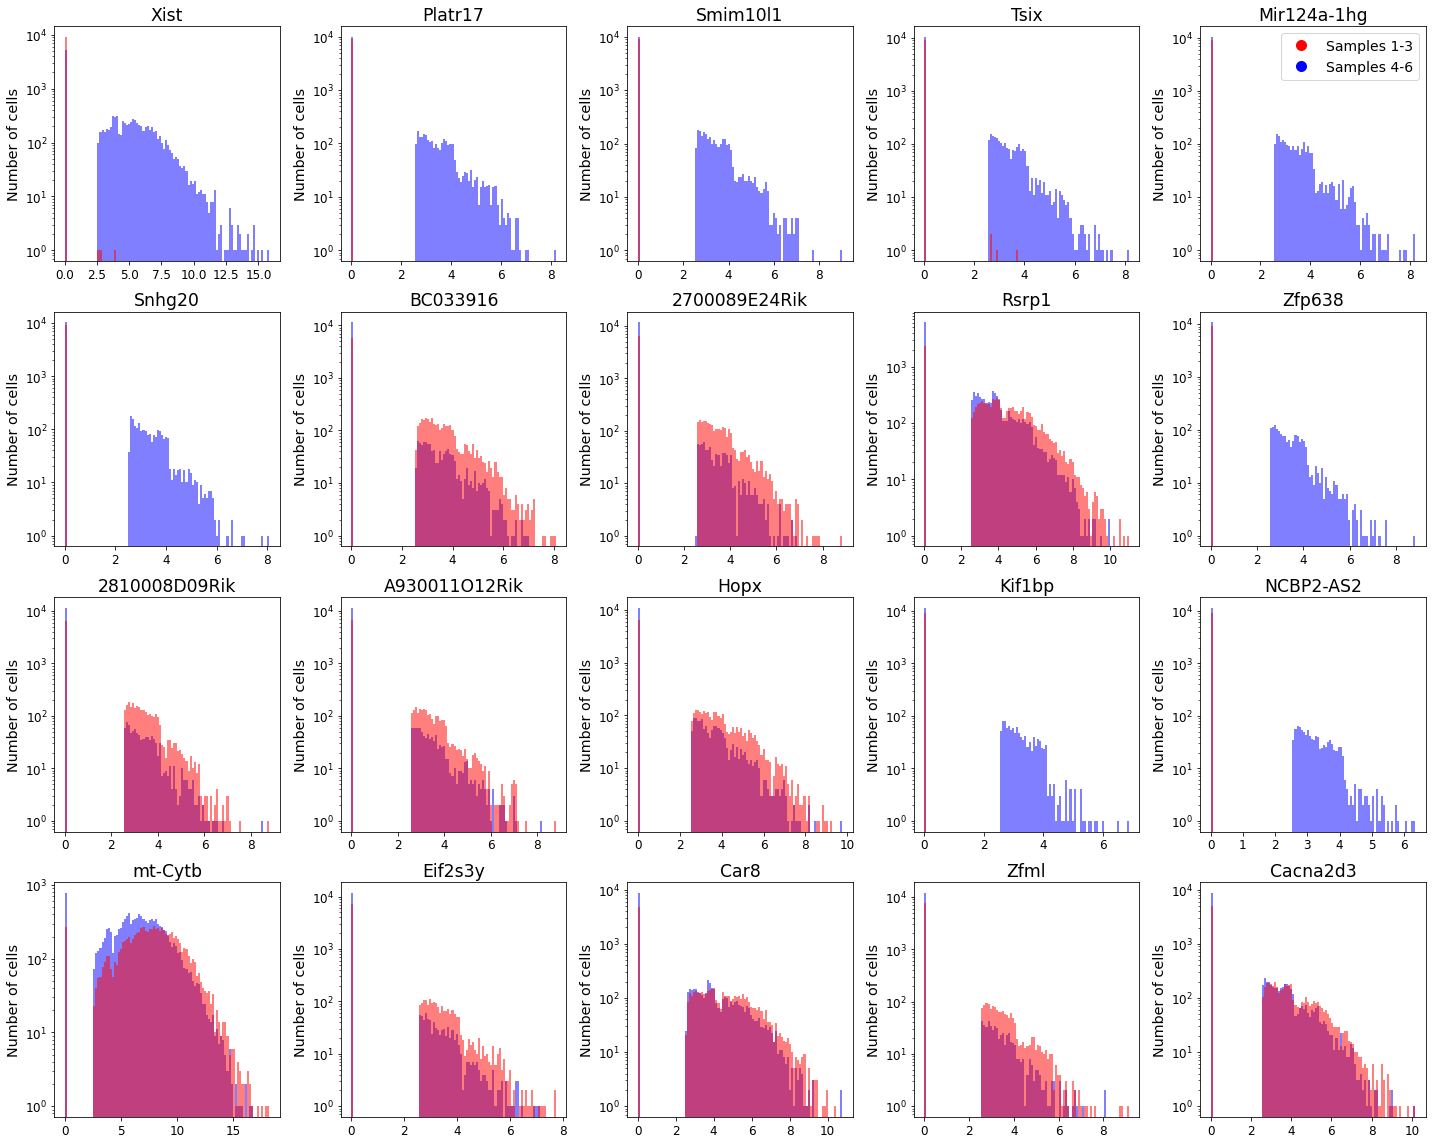

In [20]:
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
for gene, ax in zip(de_results.index, axes.flatten()):
    scprep.plot.histogram([
        data_raw.loc[metadata['sample_name'] == 'Samples 1-3', gene],
        data_raw.loc[metadata['sample_name'] == 'Samples 4-6', gene],
    ], color=['red', 'blue'], ax=ax, title=gene, log='y')

scprep.plot.tools.generate_legend({'Samples 1-3':'red', 'Samples 4-6':'blue'}, 
                                  ax=axes[0,-1], fontsize=14)
plt.tight_layout()

There seem to be two different types of genes here: one set in which Samples 1-3 have nearly zero expression ( _Xist, Platr17, Smim10l1, Tsix,_ etc ) and another where Samples have systematically higher expression ( _BC033916, 2700089E24Rik, Rsrp1,_ etc ). It's worth noting that many of these second group are poorly characterized in the literature. We should also be careful when we see a gene like _Xist_ in a list of differentially expressed genes, since this gene is strongly sex-linked.

Let's assume that we want to correct this batch effect. For more discussion of why you might _not_ want to correct it, see our materials on batch correction.

#### Correcting the batch effect

In order to run batch correction with SAUCIE, we can run SAUCIE in the same way as before, but using the keyword argument `lambda_b` (the MMD coefficient, which is set to 0 by default). The larger the coefficient, the more batch correction SAUCIE will apply.

In [23]:
# compile the tf computations for saucie
tf.reset_default_graph()
model = SAUCIE.SAUCIE(n_features, lambda_b=1)

# train the data
model.train(loader_train, steps=2000)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


#### Examining the corrected data

Now we can obtain the reconstructed data from SAUCIE, and see how well we have corrected the batch effect by looking at those same differentially expressed genes from before.

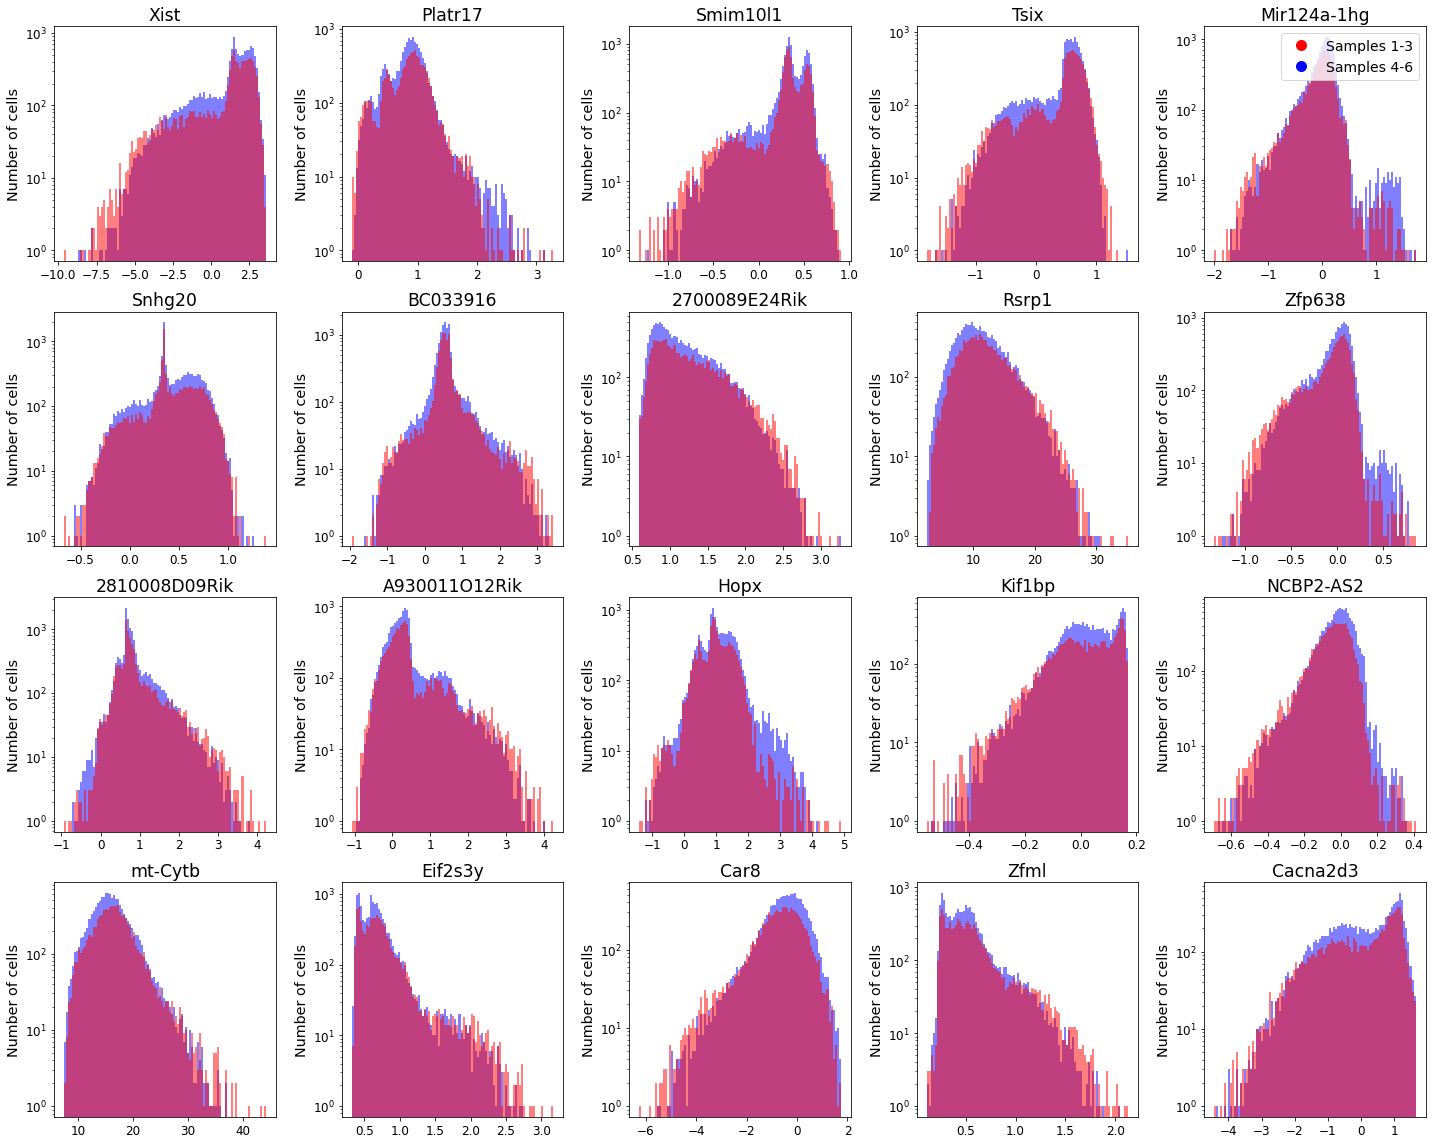

In [25]:
# get the output of SAUCIE
data_reconstructed, _ = model.get_reconstruction(loader_eval)

# invert PCA to get the reconstructed data in the ambient gene space
data_raw_reconstructed = pca_op.inverse_transform(data_reconstructed)
data_raw_reconstructed = pd.DataFrame(data_raw_reconstructed, index=data_raw.index, columns=data_raw.columns)

# plot the same genes that were differentially expressed in the original data
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
for gene, ax in zip(de_results.index, axes.flatten()):
    scprep.plot.histogram([
        data_raw_reconstructed.loc[metadata['sample_name'] == 'Samples 1-3', gene],
        data_raw_reconstructed.loc[metadata['sample_name'] == 'Samples 4-6', gene],
    ], color=['red', 'blue'], ax=ax, title=gene, log='y')

scprep.plot.tools.generate_legend({'Samples 1-3':'red', 'Samples 4-6':'blue'}, 
                                  ax=axes[0,-1], fontsize=14)
plt.tight_layout()

Note that the differences we saw earlier are now gone.

We can also examine the batch effect in the visualization space. Here we look at the visualization from SAUCIE as it was correcting the batch effect.

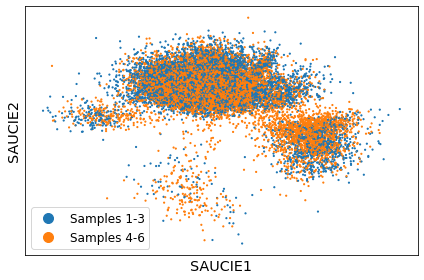

In [26]:
# visualize the data
batch_correction_embedding, _ = model.get_embedding(loader_eval)

scprep.plot.scatter2d(batch_correction_embedding, c=metadata['sample_name'], ticks=False, label_prefix="SAUCIE")

### Exercise - rerunning SAUCIE on batch corrected data

You'll notice that the embedding is far less granular than the one we saw at the beginning -- this is due to the additional constraint on the network enforced by the batch correction regularization. We can improve this somewhat by running SAUCIE again to visualize the reconstructed data.

In [4]:
# =======
# create loaders for batch-corrected data
loader_train = SAUCIE.Loader(
    data = data_reconstructed, 
    labels = metadata['sample_id'], 
    shuffle = True
)
loader_eval = SAUCIE.Loader(
    data = data_reconstructed, 
    labels = metadata['sample_id'], 
    shuffle = True
)

# compile tf computations for saucie
tf.reset_default_graph()

# build and run the model
model = SAUCIE.SAUCIE(n_features)
model.train(load = loader_train, steps=1000)
# =======

# look at the embedding layer
reconstructed_embedding, _ = model.get_embedding(loader_eval)

# plot the output
scprep.plot.scatter2d(reconstructed_embedding, 
                      c=metadata['sample_name'],
                      ticks=False, label_prefix="SAUCIE", figsize=(4,4))
scprep.plot.scatter2d(reconstructed_embedding, 
                      c=metadata['CELLTYPE'],
                      ticks=False, label_prefix="SAUCIE", figsize=(10,4), legend_anchor=(1,1))

NameError: name 'data_reconstructed' is not defined

### Discussion

1. What do you notice about the gene expression pre- and post-batch correction?
2. What do you notice about the SAUCIE visualizations from the batch correcting model, and from the secondary model that we ran on batch corrected data?
3. When might you use SAUCIE for batch correction instead of other methods like MNN?

## 5. Running SAUCIE for clustering

In order to run clustering with SAUCIE, we can run SAUCIE in the same way as before, but using the keyword argument `lambda_c` (the ID regularization coefficient, which is set to 0 by default) and `lambda_d` (the intra-cluster distance coefficient, which is set to 0 by default). The larger we set `lambda_c`, the stronger the binary assignments will be; the larger we set `lambda_d`, the more SAUCIE will expect clusters to be distinct from each other.

For the clustering to work well, we should scale the data to range between -10 and 10.

In [0]:
# rescale the data for better clustering
data_scaled = data / data.max() * 10
loader_train = SAUCIE.Loader(data_scaled, labels=metadata['sample_id'], shuffle=True)
loader_eval = SAUCIE.Loader(data_scaled, labels=metadata['sample_id'], shuffle=False)

In [33]:
# compile the tf computations for the clustering model
tf.reset_default_graph()
model = SAUCIE.SAUCIE(n_features, lambda_c=.1, lambda_d=.5)

# train the clustering model
model.train(loader_train, steps=5000)

# get the clusters out
_, clusters = model.get_clusters(loader_eval, binmin=10)
cluster_embedding, _ = model.get_embedding(loader_eval)

---- Num clusters: 28 ---- Percent clustered: 0.999 ----


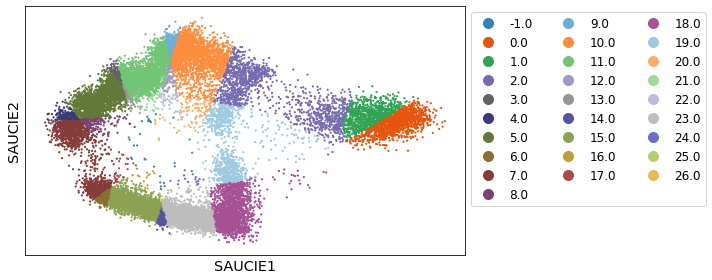

In [36]:
scprep.plot.scatter2d(cluster_embedding, c=clusters, ticks=False, label_prefix="SAUCIE", 
                      discrete=True, figsize=(10, 4), legend_anchor=(1,1))

### Exercise - understanding SAUCIE clustering

In groups, explore the effect of `lambda_c` and `lambda_d` on SAUCIE's clustering.

1. Pick one of these two coefficients to hold constant while you vary the other
2. Pick one value larger than what we used above and one value smaller.
3. Visualize the cluster assignments on both the SAUCIE visualization and another visualization of your choice (e.g. PHATE, UMAP).

In [37]:
def plot_clusters(lambda_c=0.1, lambda_d=0.5):
    # compile the tf computations for the clustering model
    tf.reset_default_graph()
    model = SAUCIE.SAUCIE(n_features, lambda_c=lambda_c, lambda_d=lambda_d)

    # train the clustering model
    model.train(loader_train, steps=5000)

    # get the clusters out
    _, clusters = model.get_clusters(loader_eval, binmin=10)
    cluster_embedding, _ = model.get_embedding(loader_eval)


    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    scprep.plot.scatter2d(embedding, c=clusters, ticks=False, label_prefix="SAUCIE", 
                          ax=ax1, discrete=True, legend=False, title="Default SAUCIE Embedding")
    scprep.plot.scatter2d(cluster_embedding, c=clusters, ticks=False, label_prefix="SAUCIE", 
                          ax=ax2, discrete=True, legend=False, title="Clustered SAUCIE Embedding")
    scprep.plot.scatter2d(alt_embedding, c=clusters, ticks=False, label_prefix="PHATE", 
                          ax=ax3, discrete=True, legend=False, title="PHATE Embedding")
    plt.tight_layout()

Calculating PHATE...
  Running PHATE on 21552 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 80.72 seconds.
    Calculating affinities...
    Calculated affinities in 35.84 seconds.
  Calculated graph and diffusion operator in 116.65 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 5.34 seconds.
    Calculating KMeans...
    Calculated KMeans in 25.78 seconds.
  Calculated landmark operator in 32.91 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 3.84 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.94 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 6.11 seconds.
Calculated PHATE in 161.48 seconds.


---- Num clusters: 6 ---- Percent clustered: 1.000 ----


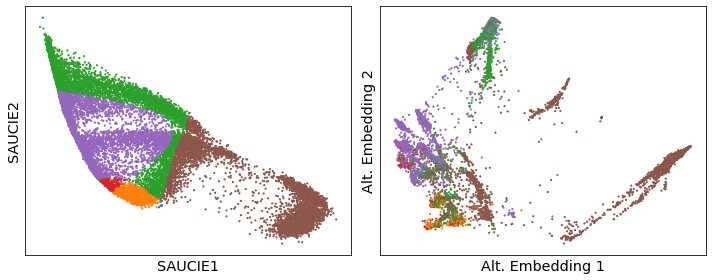

In [38]:
plot_clusters()

---- Num clusters: 57 ---- Percent clustered: 0.996 ----


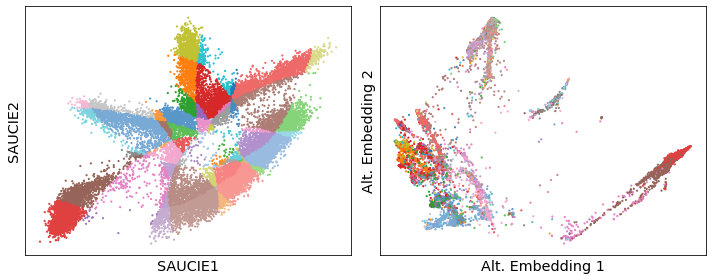

In [40]:
plot_clusters(lambda_c=0.05)

---- Num clusters: 4 ---- Percent clustered: 1.000 ----


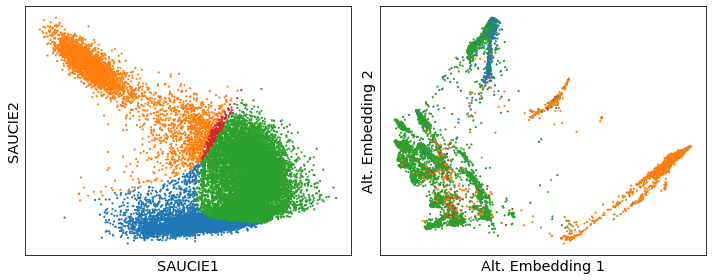

In [39]:
plot_clusters(lambda_c=0.2)

---- Num clusters: 11 ---- Percent clustered: 1.000 ----


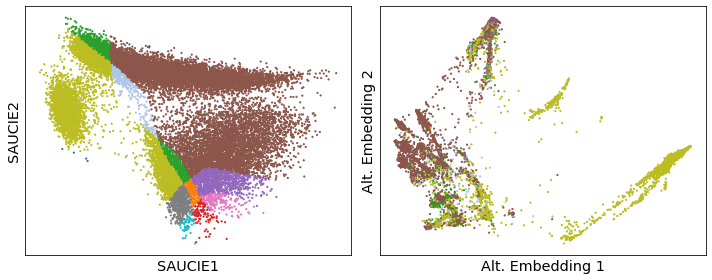

In [41]:
plot_clusters(lambda_d=0.25)

---- Num clusters: 106 ---- Percent clustered: 0.995 ----


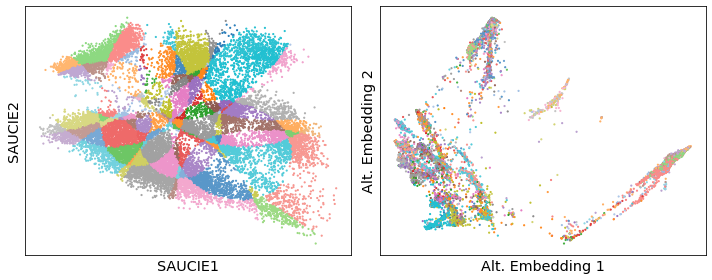

In [42]:
plot_clusters(lambda_d=1)

### Discussion

1. How does `lambda_c` affect the clustering output?
2. How does `lambda_b` affect the clustering output?
3. How does SAUCIE's clustering compare to the other clustering algorithms we have learned about?
4. Do `lambda_c` and `lambda_d` affect the SAUCIE visualization? How might you mitigate this?
5. When might you choose to use SAUCIE for clustering?